In [1]:
import pandas as pd
df = pd.read_csv('/Users/saianoopavunuri/Documents/cs_projects/flight_delay_prediction/2018.csv')

In [3]:

def get_top_k_delayed_flights_median(df, k):

    grouped = df.groupby(['OP_CARRIER', 'OP_CARRIER_FL_NUM'])

    # Filter groups with a size of at least 10
    filtered_groups = grouped.filter(lambda x: len(x) >= 500)
    
    # Calculate the median of 'DEP_DELAY' for the filtered groups
    top_10_groups = filtered_groups.groupby(['OP_CARRIER', 'OP_CARRIER_FL_NUM'])['DEP_DELAY'].median()

    # Sort the groups by the calculated median in descending order and get the top 50
    top_10_groups = top_10_groups.sort_values(ascending=False).head(k)
    return top_10_groups

print(get_top_k_delayed_flights_median(df, 20))

OP_CARRIER  OP_CARRIER_FL_NUM
DL          2398                 14.0
F9          1139                 12.0
WN          38                   11.0
B6          566                  11.0
WN          483                   8.0
UA          1551                  7.0
WN          32                    7.0
            42                    7.0
            2263                  6.0
F9          1702                  6.0
WN          44                    6.0
            878                   6.0
            63                    6.0
            160                   6.0
            2016                  6.0
            674                   6.0
            406                   5.5
            696                   5.0
            707                   5.0
            757                   5.0
Name: DEP_DELAY, dtype: float64


In [35]:
import pandas as pd
start_year = 2016
end_year = 2018

def get_combined_years_df(carrier, flight_number, start_year, end_year, exclude=None):
    ans = None
    for year in range(start_year, end_year+1):
        df = pd.read_csv(f"/Users/saianoopavunuri/Documents/cs_projects/flight_delay_prediction/{year}.csv")
        if ans is None:
            ans = df[(df['OP_CARRIER'] == carrier) & (df['OP_CARRIER_FL_NUM'] == flight_number)]
            continue
        ans = pd.concat([ans, df[(df['OP_CARRIER'] == carrier) & (df['OP_CARRIER_FL_NUM'] == flight_number)]])
    
    return ans


SELECTED_OP_CARRIER = 'DL'
SELECTED_FL_NUM = 2398

# Combine multiple years for a single flight path
df = get_combined_years_df(SELECTED_OP_CARRIER, SELECTED_FL_NUM, start_year, end_year)

# Combine multiple flights for a year
# df = pd.read_csv('/Users/saianoopavunuri/Documents/cs_projects/flight_delay_prediction/2018.csv')

# # Group by ORIGIN, DEST, and OP_CARRIER and count occurrences, then sort
# top_50_groups = df.groupby(['ORIGIN', 'DEST', 'OP_CARRIER']).size().sort_values(ascending=False).head(10)

# # Convert MultiIndex to a list of lists
# routes = [list(idx) for idx in top_50_groups.index]

# temp = pd.DataFrame()
# for route in routes:
#     origin, dest, carrier = route[0], route[1], route[2]
#     temp = pd.concat([temp, df[(df['OP_CARRIER'] == carrier) & (df['ORIGIN'] == origin) & (df['DEST'] == dest)]])
# df = temp

In [36]:
"""Preprocessing the dataframe"""

filtered_df = df[(df['OP_CARRIER'] == SELECTED_OP_CARRIER) & (df['OP_CARRIER_FL_NUM'] == SELECTED_FL_NUM)]
filtered_df = filtered_df.reset_index()

filtered_df['DEP_DELAY'] = filtered_df['DEP_DELAY'].apply(lambda x: max(0,x))
#filtered_df['DEP_DELAY'] = filtered_df['DEP_DELAY'].apply(lambda x: min(90,x))


# Convert the time column to a string and format it
filtered_df['CRS_DEP_TIME'] = filtered_df['CRS_DEP_TIME'].apply(lambda x: '{:04.0f}'.format(x))
filtered_df['CRS_DEP_TIME'] = filtered_df['CRS_DEP_TIME'].str[:2] + ':' + filtered_df['CRS_DEP_TIME'].str[2:]

# Combine date and time columns
filtered_df['datetime'] = pd.to_datetime(filtered_df['FL_DATE'] + ' ' + filtered_df['CRS_DEP_TIME'])
DROPPED_COLUMNS = ['CANCELLATION_CODE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'Unnamed: 27', 'NAS_DELAY', 'CANCELLED', 'DIVERTED']
filtered_df = filtered_df.drop(columns=DROPPED_COLUMNS)
filtered_df.dropna(inplace=True)

data = filtered_df.copy()
# Convert the time column to a string and format it
data['CRS_DEP_TIME'] = data['CRS_DEP_TIME'].apply(lambda x: x.replace(":","")).astype(int).apply(lambda x: '{:04.0f}'.format(x))
data['CRS_DEP_TIME'] = data['CRS_DEP_TIME'].str[:2] + ':' + data['CRS_DEP_TIME'].str[2:]

# Combine date and time columns
data['datetime'] = pd.to_datetime(data['FL_DATE'] + ' ' + data['CRS_DEP_TIME'])
data = data.sort_values(by='datetime')
data.reset_index(inplace=True)

# Convert datetime to its components
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour
data['dayofweek'] = data['datetime'].dt.dayofweek  # Monday=0, Sunday=6

# One-hot encode the time variables
data = pd.get_dummies(data, columns=['month', 'day', 'hour', 'dayofweek'])


In [37]:
data

,level_0,index,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,...,hour_19,hour_20,hour_21,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
0,0,12436,2016-01-01,DL,2398,DTW,DCA,19:55,2002.0,7.0,...,1,0,0,0,0,0,0,1,0,0
1,1,25511,2016-01-02,DL,2398,DTW,DCA,19:55,1955.0,0.0,...,1,0,0,0,0,0,0,0,1,0
2,2,29729,2016-01-03,DL,2398,DTW,DCA,19:55,1947.0,0.0,...,1,0,0,0,0,0,0,0,0,1
3,3,51840,2016-01-04,DL,2398,DTW,DCA,19:55,2039.0,44.0,...,1,0,0,1,0,0,0,0,0,0
4,4,61552,2016-01-05,DL,2398,LGA,DTW,18:40,1838.0,0.0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,1569,7145874,2018-12-28,DL,2398,EWR,ATL,17:59,1827.0,28.0,...,0,0,0,0,0,0,0,1,0,0
1544,1570,7160694,2018-12-29,DL,2398,ATL,EWR,15:02,1500.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1545,1571,7160695,2018-12-29,DL,2398,EWR,ATL,17:59,1754.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1546,1572,7187114,2018-12-30,DL,2398,ATL,EWR,15:02,1546.0,44.0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
"""Weather data merging given latitude and longitude of starting airport"""

import requests
lat = 38.95
long = -77.46
response = requests.get(f'https://archive-api.open-meteo.com/v1/archive?latitude={lat}&longitude={long}&start_date={start_year}-01-01&end_date={end_year}-12-31&hourly=temperature_2m,rain,snowfall,cloudcover,windspeed_100m')
weather = response.json()

weather_dict = {}
from datetime import datetime
for i, date in enumerate(weather['hourly']['time']):
    hour  = datetime.strptime(date, "%Y-%m-%dT%H:%M")
    weather_dict[hour] = {'temperature_2m': weather['hourly']['temperature_2m'][i],'rain': weather['hourly']['rain'][i], 'snowfall': weather['hourly']['snowfall'][i], 'cloudcover': weather['hourly']['cloudcover'][i], 'windspeed_100m': weather['hourly']['windspeed_100m'][i] }

# Floor the datetime to the nearest hour
data["floored_datetime"] = data["datetime"].dt.floor("H")

# Look up the weather data and add new columns to the DataFrame
for feature in ['temperature_2m', 'rain', 'snowfall', 'cloudcover', 'windspeed_100m']:
    data[feature] = data["floored_datetime"].map(lambda x: weather_dict.get(x, {}).get(feature, None))

# Drop the 'floored_datetime' column if not needed
data.drop(columns=["floored_datetime"], inplace=True)
data = data.sort_values(by='datetime')


In [6]:
data['DEP_DELAY'].describe()

count    579.000000
mean      43.077720
std       78.331382
min        0.000000
25%        0.000000
50%       14.000000
75%       44.000000
max      904.000000
Name: DEP_DELAY, dtype: float64

In [38]:
data['DEST'].value_counts()

ATL    649
EWR    567
IND     69
MSP     60
SEA     56
DCA     52
DTW     31
TLH     28
PHX     27
MCO      9
Name: DEST, dtype: int64

In [40]:
data = data[data['DEST'].str.contains('ATL|EWR') & data['ORIGIN'].str.contains('ATL|EWR')]

In [41]:
data

,level_0,index,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,...,hour_19,hour_20,hour_21,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
446,447,692296,2017-02-17,DL,2398,ATL,EWR,15:15,1618.0,63.0,...,0,0,0,0,0,0,0,1,0,0
447,448,692297,2017-02-17,DL,2398,EWR,ATL,18:15,2157.0,222.0,...,0,0,0,0,0,0,0,1,0,0
448,449,718828,2017-02-19,DL,2398,ATL,EWR,15:15,1510.0,0.0,...,0,0,0,0,0,0,0,0,0,1
449,450,729908,2017-02-20,DL,2398,ATL,EWR,15:15,1512.0,0.0,...,0,0,0,1,0,0,0,0,0,0
450,451,729909,2017-02-20,DL,2398,EWR,ATL,18:15,1810.0,0.0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,1569,7145874,2018-12-28,DL,2398,EWR,ATL,17:59,1827.0,28.0,...,0,0,0,0,0,0,0,1,0,0
1544,1570,7160694,2018-12-29,DL,2398,ATL,EWR,15:02,1500.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1545,1571,7160695,2018-12-29,DL,2398,EWR,ATL,17:59,1754.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1546,1572,7187114,2018-12-30,DL,2398,ATL,EWR,15:02,1546.0,44.0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Function to remove outliers based on IQR
def remove_outliers_iqr(df, column_name, lower_percentile=0.25, upper_percentile=0.75, threshold=1.5):
    q1 = df[column_name].quantile(lower_percentile)
    q3 = df[column_name].quantile(upper_percentile)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    df_filtered = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)].copy()
    return df_filtered


# Specify the column name for which you want to remove outliers
column_name = 'DEP_DELAY'

# Remove outliers and get the cleaned DataFrame
data = remove_outliers_iqr(data, column_name)

print(data.shape)

In [44]:
""" Only keep rows that had all the flights that day so sequence length stays same"""

mask = data.groupby('FL_DATE')['FL_DATE'].transform('size') > 1
data = data[mask]


In [45]:
data['DEP_DELAY'].describe()

count    1052.000000
mean       45.260456
std        71.021583
min         0.000000
25%         0.000000
50%        21.000000
75%        57.000000
max       904.000000
Name: DEP_DELAY, dtype: float64

In [46]:
data

,level_0,index,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,...,hour_19,hour_20,hour_21,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
446,447,692296,2017-02-17,DL,2398,ATL,EWR,15:15,1618.0,63.0,...,0,0,0,0,0,0,0,1,0,0
447,448,692297,2017-02-17,DL,2398,EWR,ATL,18:15,2157.0,222.0,...,0,0,0,0,0,0,0,1,0,0
449,450,729908,2017-02-20,DL,2398,ATL,EWR,15:15,1512.0,0.0,...,0,0,0,1,0,0,0,0,0,0
450,451,729909,2017-02-20,DL,2398,EWR,ATL,18:15,1810.0,0.0,...,0,0,0,1,0,0,0,0,0,0
451,452,749500,2017-02-21,DL,2398,ATL,EWR,15:15,1513.0,0.0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,1569,7145874,2018-12-28,DL,2398,EWR,ATL,17:59,1827.0,28.0,...,0,0,0,0,0,0,0,1,0,0
1544,1570,7160694,2018-12-29,DL,2398,ATL,EWR,15:02,1500.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1545,1571,7160695,2018-12-29,DL,2398,EWR,ATL,17:59,1754.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1546,1572,7187114,2018-12-30,DL,2398,ATL,EWR,15:02,1546.0,44.0,...,0,0,0,0,0,0,0,0,0,1


In [47]:
"""Split into classification bins"""

data['DEP_CAT'] = data['DEP_DELAY'].apply(lambda x: '0-30' if x <= 30 else ('30-60' if x <= 60 else '60+'))

/var/folders/2t/mfs621pj7r38pl663d60tjmw0000gn/T/ipykernel_35004/3213445679.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['DEP_CAT'] = data['DEP_DELAY'].apply(lambda x: '0-30' if x <= 30 else ('30-60' if x <= 60 else '60+'))


In [48]:
data

,level_0,index,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,...,hour_20,hour_21,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,DEP_CAT
446,447,692296,2017-02-17,DL,2398,ATL,EWR,15:15,1618.0,63.0,...,0,0,0,0,0,0,1,0,0,60+
447,448,692297,2017-02-17,DL,2398,EWR,ATL,18:15,2157.0,222.0,...,0,0,0,0,0,0,1,0,0,60+
449,450,729908,2017-02-20,DL,2398,ATL,EWR,15:15,1512.0,0.0,...,0,0,1,0,0,0,0,0,0,0-30
450,451,729909,2017-02-20,DL,2398,EWR,ATL,18:15,1810.0,0.0,...,0,0,1,0,0,0,0,0,0,0-30
451,452,749500,2017-02-21,DL,2398,ATL,EWR,15:15,1513.0,0.0,...,0,0,0,1,0,0,0,0,0,0-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,1569,7145874,2018-12-28,DL,2398,EWR,ATL,17:59,1827.0,28.0,...,0,0,0,0,0,0,1,0,0,0-30
1544,1570,7160694,2018-12-29,DL,2398,ATL,EWR,15:02,1500.0,0.0,...,0,0,0,0,0,0,0,1,0,0-30
1545,1571,7160695,2018-12-29,DL,2398,EWR,ATL,17:59,1754.0,0.0,...,0,0,0,0,0,0,0,1,0,0-30
1546,1572,7187114,2018-12-30,DL,2398,ATL,EWR,15:02,1546.0,44.0,...,0,0,0,0,0,0,0,0,1,30-60


In [49]:
""" Encode the Y based on departure category """

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Assuming 'data' has a 'DEP_CAT' column
data['DEP_CAT'] = data['DEP_DELAY'].apply(lambda x: '0-30' if x <= 30 else ('30-60' if x <= 60 else '60+'))

# Encoding the labels
encoder = LabelEncoder()
encoded_Y = encoder.fit_transform(data['DEP_CAT'])
dummy_y = to_categorical(encoded_Y)


/var/folders/2t/mfs621pj7r38pl663d60tjmw0000gn/T/ipykernel_35004/2035850258.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['DEP_CAT'] = data['DEP_DELAY'].apply(lambda x: '0-30' if x <= 30 else ('30-60' if x <= 60 else '60+'))


In [50]:
""" Create sequences for the LSTM model """

import numpy as np

def create_sequences(features, target, window_size):
    X, y = [], []
    for i in range(0,len(features) - window_size, window_size+1):
        X.append(features[i:i+window_size])
        y.append(target[i+window_size])
    return np.array(X), np.array(y)

window_size = 1
features = data[[col for col in data.columns if 'month_' in col or 'day_' in col or 'hour_' in col or 'dayofweek_' in col] + ['DEP_DELAY']]

X, y = create_sequences(features.values, dummy_y, window_size)


In [51]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Number of categories
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num_categories = dummy_y.shape[1]

model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(80, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dense(num_categories, activation='softmax'))  # Change for classification
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Change loss and metric

# Train model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), shuffle=False)

# Predict
y_pred = model.predict(X_test)

Epoch 1/20
14/14 [==============================] - 2s 35ms/step - loss: 1.0785 - accuracy: 0.7095 - val_loss: 1.0578 - val_accuracy: 0.7358
Epoch 2/20
14/14 [==============================] - 0s 4ms/step - loss: 1.0102 - accuracy: 0.8048 - val_loss: 0.9773 - val_accuracy: 0.7075
Epoch 3/20
14/14 [==============================] - 0s 4ms/step - loss: 0.8632 - accuracy: 0.8238 - val_loss: 0.8100 - val_accuracy: 0.7547
Epoch 4/20
14/14 [==============================] - 0s 4ms/step - loss: 0.6426 - accuracy: 0.8429 - val_loss: 0.6390 - val_accuracy: 0.7642
Epoch 5/20
14/14 [==============================] - 0s 4ms/step - loss: 0.4998 - accuracy: 0.8310 - val_loss: 0.5741 - val_accuracy: 0.7547
Epoch 6/20
14/14 [==============================] - 0s 4ms/step - loss: 0.4421 - accuracy: 0.8286 - val_loss: 0.5405 - val_accuracy: 0.7547
Epoch 7/20
14/14 [==============================] - 0s 3ms/step - loss: 0.4089 - accuracy: 0.8357 - val_loss: 0.5332 - val_accuracy: 0.7547
Epoch 8/20
14/14 [=

In [52]:
for index in range(10):
    print(X_test[index,0,-1], y_test[index], y_pred[index])

17.0 [1. 0. 0.] [0.91156095 0.06754567 0.02089333]
0.0 [1. 0. 0.] [0.99671006 0.00228915 0.00100079]
45.0 [0. 1. 0.] [0.16284439 0.65095323 0.18620235]
30.0 [1. 0. 0.] [0.5916466  0.3259865  0.08236694]
56.0 [0. 0. 1.] [0.0045592 0.4016563 0.5937846]
0.0 [1. 0. 0.] [0.9964484  0.002476   0.00107561]
44.0 [0. 1. 0.] [0.17467754 0.64456254 0.18075985]
87.0 [0. 0. 1.] [5.9171686e-07 1.2703950e-02 9.8729545e-01]
0.0 [1. 0. 0.] [9.9789798e-01 1.4742358e-03 6.2770082e-04]
0.0 [1. 0. 0.] [9.9689877e-01 2.1807458e-03 9.2054851e-04]


In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert one-hot encoded predictions to labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_labels, y_pred_labels)
print(f"Accuracy: {accuracy}")

# You can also calculate other metrics like precision, recall, and F1-score if needed
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


Accuracy: 0.8490566037735849
Precision: 0.850335635590604
Recall: 0.8490566037735849
F1-score: 0.8487263546641413


In [56]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


def create_sequences(data, window_size):
    X, y = [], []
    for i in range(0,len(data) - window_size, window_size+1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size, -1])
    return np.array(X), np.array(y)

# Using past 5 hours to predict the next hour's delay
window_size = 1


# features = data[['rain', 'windspeed_100m'] + [col for col in data.columns if 'month_' in col or 'day_' in col or 'hour_' in col or 'dayofweek_' in col]+ ['ARR_DELAY','DEP_DELAY']]
features = data[[col for col in data.columns if 'month_' in col or 'day_' in col or 'hour_' in col or 'dayofweek_' in col] + ['DEP_DELAY']]

X, y = create_sequences(features.values, window_size)
#y = data['DEP_DELAY'].values[window_size:]

# Reshape X for LSTM [samples, timesteps, features]
X = X.reshape(X.shape[0], X.shape[1], features.shape[1])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model with Stacked layers
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True)) # Add return_sequences=True for stacking
model.add(Dropout(0.3))
# Second LSTM layer
model.add(LSTM(80, return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(80, return_sequences=True))
model.add(Dropout(0.3))

# Third LSTM layer
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.3))

model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))

model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# Train model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), shuffle=False)

# Predict
y_pred = model.predict(X_test)


Epoch 1/20
14/14 [==============================] - 3s 45ms/step - loss: 8890.5244 - val_loss: 6296.1685
Epoch 2/20
14/14 [==============================] - 0s 5ms/step - loss: 8819.3564 - val_loss: 6095.4951
Epoch 3/20
14/14 [==============================] - 0s 5ms/step - loss: 8203.1680 - val_loss: 4586.5322
Epoch 4/20
14/14 [==============================] - 0s 5ms/step - loss: 5954.1367 - val_loss: 3375.2246
Epoch 5/20
14/14 [==============================] - 0s 5ms/step - loss: 5101.8745 - val_loss: 3225.5242
Epoch 6/20
14/14 [==============================] - 0s 6ms/step - loss: 4706.2705 - val_loss: 2607.9392
Epoch 7/20
14/14 [==============================] - 0s 5ms/step - loss: 3912.1580 - val_loss: 1810.4390
Epoch 8/20
14/14 [==============================] - 0s 4ms/step - loss: 3015.7922 - val_loss: 1320.0201
Epoch 9/20
14/14 [==============================] - 0s 4ms/step - loss: 2547.3870 - val_loss: 1292.7382
Epoch 10/20
14/14 [==============================] - 0s 4ms/ste

In [30]:
from sklearn.metrics import mean_squared_error
from math import sqrt


# Compute RMSE
rmse = sqrt(mean_squared_error(y_pred, y_test))
print(f"Root Mean Square Error (RMSE): {rmse}")

Root Mean Square Error (RMSE): 36.78794665673978


In [ ]:
for index in range(10):
    print(X_test[index,0,-1], y_test[index], y_pred[index])

In [31]:
"""Linear Regression model for when the window size is just 1"""

x_sam = []
y_sam = []
y_same = []
for index in range(len(X)):
    x_sam.append(X[index,0,-1])
    y_sam.append(y[index])
    y_same.append(x_sam[-1])

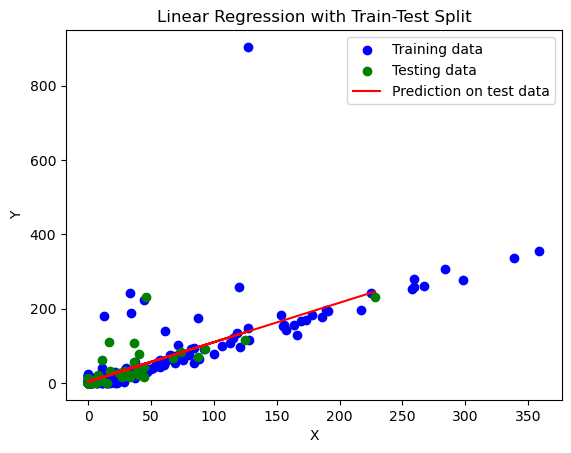

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

x_sam = np.array(x_sam).reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(x_sam, y_sam, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Fit the model with the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Plotting
plt.scatter(X_train, y_train, color='blue', label='Training data')
plt.scatter(X_test, y_test, color='green', label='Testing data')
plt.plot(X_test, y_pred, color='red', label='Prediction on test data')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Linear Regression with Train-Test Split')
plt.legend()
plt.show()


In [33]:
from sklearn.metrics import mean_squared_error
from math import sqrt


# Compute RMSE
rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Square Error (RMSE): {rmse}")

Root Mean Square Error (RMSE): 31.66881504568817


In [ ]:
# multiple routes simple model no weather


import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Using past 5 hours to predict the next hour's delay
window_size = 8

# Convert datetime to its components
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour
data['dayofweek'] = data['datetime'].dt.dayofweek  # Monday=0, Sunday=6

# One-hot encode the time variables
data = pd.get_dummies(data, columns=['month', 'day', 'hour', 'dayofweek'])


X, y = [], []


for route in routes:
    origin, dest, carrier = route[0], route[1], route[2]
    temp = data[(data['OP_CARRIER'] == carrier) & (data['ORIGIN'] == origin) & (data['DEST'] == dest)]
    features = temp[[col for col in temp.columns if 'month_' in col or 'day_' in col or 'hour_' in col or 'dayofweek_' in col] + ['DEP_DELAY'] + ['ARR_DELAY']]
    
    X1, y1 = create_sequences(features.values, window_size)
    # X, y = create_sequences(features.values, window_size)
    y1 = temp['DEP_DELAY'].values[window_size:]
    X1 = X1.reshape(X1.shape[0], X1.shape[1], features.shape[1])

    # Append the sequences for this route to the overall X and y
    if len(X1) > 0:
        if len(X) == 0:
            X = X1
            y = y1
        else:
            X = np.concatenate((X, X1), axis=0)
            y = np.concatenate((y, y1), axis=0)

# Reshape X for LSTM [samples, timesteps, features]
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model with Stacked layers
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False)) # Add return_sequences=True for stacking
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), shuffle=False)

# Predict
y_pred = model.predict(X_test)


In [ ]:
"""More complex model with normalized data as well"""


import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Sample data loading (please ensure you have loaded your data into the 'data' variable)
# data = pd.read_csv('your_data_path.csv')

# Using past 8 hours to predict the next hour's delay
window_size = 8

# Convert datetime to its components
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour
data['dayofweek'] = data['datetime'].dt.dayofweek  # Monday=0, Sunday=6

features = data[['month', 'day', 'hour', 'dayofweek', 'rain', 'snowfall', 'windspeed_100m']]
X, y = create_sequences(features.values, window_size)
y = data['DEP_DELAY'].values[window_size:]

# Feature Standardization
scaler_X = MinMaxScaler()
X = scaler_X.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model with Stacked layers
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True)) # Add return_sequences=True for stacking
model.add(Dropout(0.3))
model.add(LSTM(30, return_sequences=False))  # Additional LSTM layer
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Train model with Callbacks
model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), shuffle=False, callbacks=[early_stopping, reduce_lr])

# Predict
y_pred = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred)  # Inverse scaling for predictions
y_test = scaler_y.inverse_transform(y_test)


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt


# Compute RMSE
rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Square Error (RMSE): {rmse}")


In [ ]:
""" We tried binning the predictions of the LSTM after it gave a DEP DELAY predicted"""

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Sample data
y_true = y_test

# Define a function to bin the values
def bin_values(values):
    bins = [0, 30, 60, float('inf')]
    labels = ['0-30', '30-60', '60+']
    return np.digitize(values, bins=bins, right=False).astype(str)

# Bin the true and predicted values
binned_y_true = bin_values(y_true)
binned_y_pred = bin_values(y_pred)

# Calculate classification metrics
print("Confusion Matrix:")
print(confusion_matrix(binned_y_true, binned_y_pred))
print("\nClassification Report:")
print(classification_report(binned_y_true, binned_y_pred))
print("\nAccuracy Score:")
print(accuracy_score(binned_y_true, binned_y_pred))


In [ ]:
""" Code below is when we tried adding weather data of arrival airport as well... did not help"""
response2 = requests.get('https://archive-api.open-meteo.com/v1/archive?latitude=33.75&longitude=-84.39&start_date=2017-01-01&end_date=2018-12-31&hourly=temperature_2m,rain,snowfall,cloudcover,windspeed_100m')
weather2 = response2.json()
weather_dict = {}
from datetime import datetime
for i, date in enumerate(weather2['hourly']['time']):
    hour  = datetime.strptime(date, "%Y-%m-%dT%H:%M")
    weather_dict[hour] = {'temperature_2m': weather2['hourly']['temperature_2m'][i],'rain': weather2['hourly']['rain'][i], 'snowfall': weather2['hourly']['snowfall'][i], 'cloudcover': weather2['hourly']['cloudcover'][i], 'windspeed_100m': weather2['hourly']['windspeed_100m'][i] }

# Floor the datetime to the nearest hour
data["floored_datetime"] = data["datetime"].dt.floor("H") + pd.Timedelta(hours=2)

# Look up the weather data and add new columns to the DataFrame
for feature in ['temperature_2m', 'rain', 'snowfall', 'cloudcover', 'windspeed_100m','precipitation']:
    data[feature+"_arr" + "_2hr"] = data["floored_datetime"].map(lambda x: weather_dict.get(x, {}).get(feature, None))

# Drop the 'floored_datetime' column if not needed
data.drop(columns=["floored_datetime"], inplace=True)


In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Using past 5 hours to predict the next hour's delay
window_size = 8

# Convert datetime to its components
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour
data['dayofweek'] = data['datetime'].dt.dayofweek  # Monday=0, Sunday=6

features = data[['month', 'day', 'hour', 'dayofweek', 'rain', 'snowfall', 'windspeed_100m', 'rain_arr_2hr','snowfall_arr_2hr', 'windspeed_100m_arr_2hr']]
X, y = create_sequences(features.values, window_size)
y = data['DEP_DELAY'].values[window_size:]

# Reshape X for LSTM [samples, timesteps, features]
X = X.reshape(X.shape[0], X.shape[1], features.shape[1])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train model
model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), shuffle=False)

# Predict
y_pred = model.predict(X_test)
